<a href="https://colab.research.google.com/github/ashwantmanikoth/Sentiment-Analysis/blob/main/Variational%20encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.datasets import cifar10
from keras.layers import Input, Dense, Flatten, Reshape
from keras.models import Model
import numpy as np






In [ ]:
from keras.layers import Input, Dense, Flatten, Reshape, Conv2D, UpSampling2D,MaxPooling2D
from keras.models import Model
from keras.datasets import fashion_mnist  # Import Fashion MNIST dataset
from keras.optimizers import Adam
import numpy as np

# Load the Fashion MNIST dataset
(x_train, _), (x_test, _) = fashion_mnist.load_data()

# Normalize pixel values to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


# Reshape Fashion MNIST images to (28, 28, 1) to match the input shape
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)


In [ ]:

# Define the encoding dimension as a variable
encoding_dim = 128

input_img = Input(shape=(28, 28, 1))  # Fashion MNIST images are 28x28x1

# Encoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
x = Dense(encoding_dim, activation='relu')(x)  # Use the encoding_dim variable here

# Decoder
x = Dense(7 * 7 * 128, activation='relu')(x)  # Adjust the shape for Fashion MNIST
x = Reshape((7, 7, 128))(x)  # Adjust the shape for Fashion MNIST
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # Output has one channel for grayscale

# Create and compile the model with the custom optimizer
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy')

# Train the autoencoder
history = autoencoder.fit(x_train, x_train, epochs=4, batch_size=256, validation_data=(x_test, x_test))

Epoch 1/4
235/235 [==============================] - 6s 17ms/step - loss: 0.3269 - val_loss: 0.2879
Epoch 2/4
235/235 [==============================] - 4s 16ms/step - loss: 0.2788 - val_loss: 0.2760
Epoch 3/4
235/235 [==============================] - 4s 16ms/step - loss: 0.2704 - val_loss: 0.2697
Epoch 4/4
235/235 [==============================] - 4s 16ms/step - loss: 0.2664 - val_loss: 0.2676


1/1 [==============================] - 0s 151ms/step


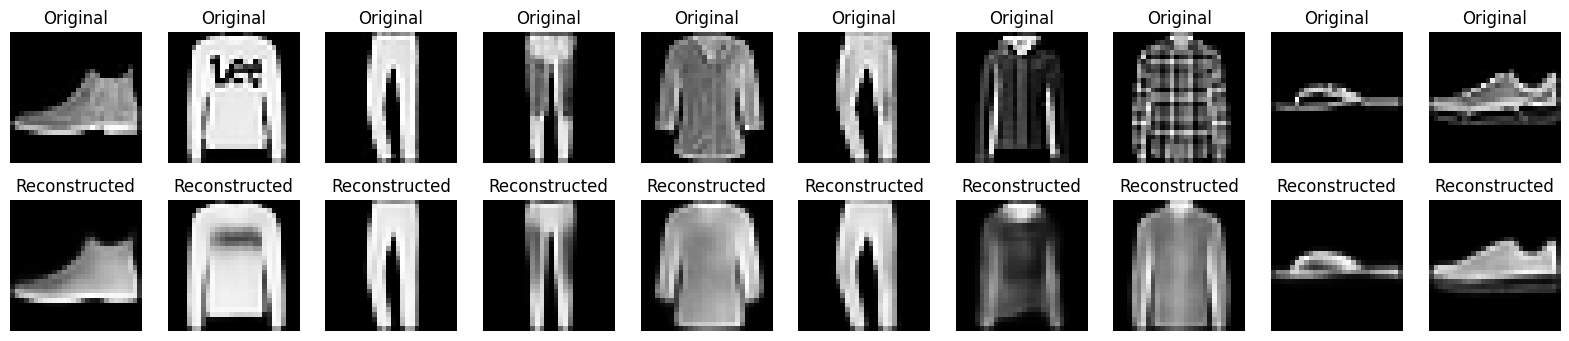

In [ ]:
n = 10  # Number of images to display
sample_images = x_test[:n]
reconstructed_images = autoencoder.predict(sample_images)

plt.figure(figsize=(20, 4))
for i in range(n):
    # Original Image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(sample_images[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed Image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()

313/313 [==============================] - 1s 2ms/step
Mean Squared Error (MSE): 0.0081
Mean Absolute Error (MAE): 0.0445


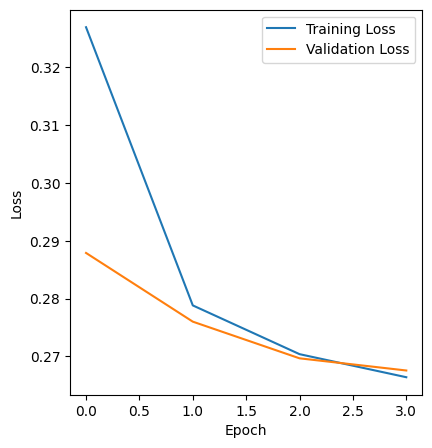

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Calculate reconstruction errors
decoded_images = autoencoder.predict(x_test)

# Calculate Mean Squared Error (MSE) and Mean Absolute Error (MAE)
mse = mean_squared_error(x_test.reshape(-1, 28*28), decoded_images.reshape(-1, 28*28))
mae = mean_absolute_error(x_test.reshape(-1, 28*28), decoded_images.reshape(-1, 28*28))

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Show the plots
plt.show()



Variational Auto Encoders

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from keras.losses import mse
from keras import backend as K

# Load the Fashion MNIST dataset
(x1_train, _), (x1_test, _) = fashion_mnist.load_data()

# Normalize pixel values to the range [0, 1]
x1_train = x1_train.astype('float32') / 255.0
x1_test = x1_test.astype('float32') / 255.0

# Flatten the images
x1_train = x1_train.reshape((len(x1_train), np.prod(x1_train.shape[1:])))
x1_test = x1_test.reshape((len(x1_test), np.prod(x1_test.shape[1:])))

# Define the encoding and latent dimensions as variables
encoding_dim = 64  # Adjust as needed
latent_dim = 10    # Adjust as needed

# Encoder
input_img = Input(shape=(784,))
x = Dense(256, activation='relu')(input_img)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

# Sampling function to sample from the latent space
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.0)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

# Decoder
decoder_input = Input(shape=(latent_dim,))
x = Dense(256, activation='relu')(decoder_input)
outputs = Dense(784, activation='sigmoid')(x)

# Create the encoder and decoder models
encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_input, outputs, name='decoder')

# VAE model, connecting the encoder and decoder
outputs = decoder(encoder(input_img)[2])
vae = Model(input_img, outputs, name='vae')

# KL divergence loss
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae.add_loss(K.mean(kl_loss))

vae.compile(optimizer=Adam(lr=0.001), loss=mse)



In [39]:

# Train the custom VAE
history = vae.fit(x1_train, x1_train, epochs=3, batch_size=128, validation_data=(x1_test, x1_test), verbose=2)



Epoch 1/3
469/469 - 2s - loss: 0.0873 - val_loss: 0.0868 - 2s/epoch - 4ms/step
Epoch 2/3
469/469 - 2s - loss: 0.0872 - val_loss: 0.0869 - 2s/epoch - 4ms/step
Epoch 3/3
469/469 - 2s - loss: 0.0872 - val_loss: 0.0868 - 2s/epoch - 4ms/step


1/1 [==============================] - 0s 20ms/step


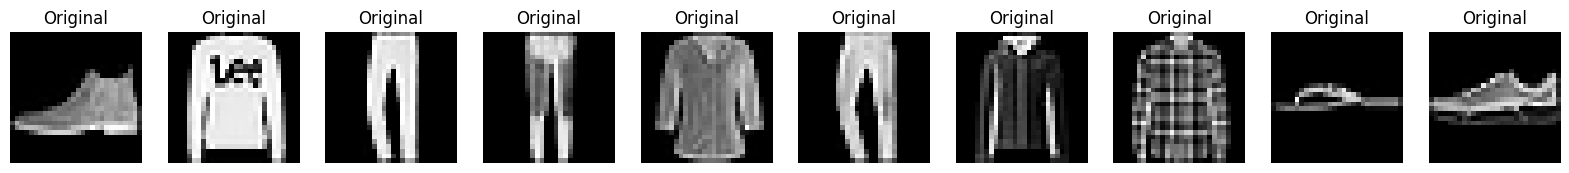

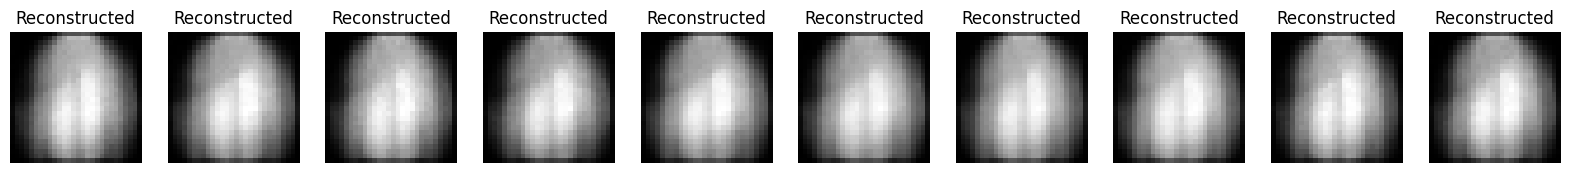

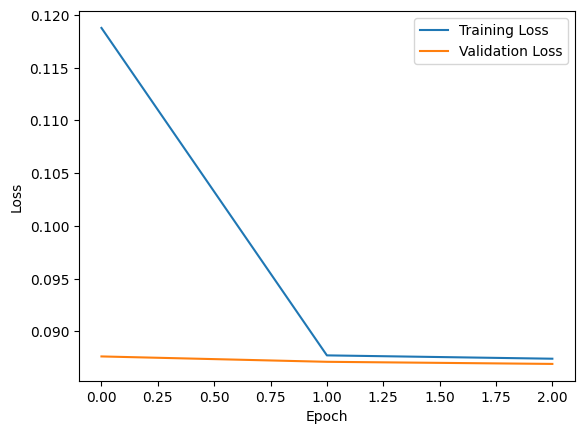

In [37]:
# Display a few original images and their reconstructed counterparts
n = 10  # Number of images to display
sample_images = x1_test[:n]
reconstructed_images = vae.predict(sample_images)

plt.figure(figsize=(20, 4))
for i in range(n):
    # Original Image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(sample_images[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')



plt.show()
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()


# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch 1/30
469/469 - 5s - loss: 0.0997 - val_loss: 0.0872 - 5s/epoch - 10ms/step
Epoch 2/30
469/469 - 2s - loss: 0.0873 - val_loss: 0.0868 - 2s/epoch - 4ms/step
Epoch 3/30
469/469 - 2s - loss: 0.0872 - val_loss: 0.0868 - 2s/epoch - 5ms/step
Epoch 4/30
469/469 - 2s - loss: 0.0872 - val_loss: 0.0868 - 2s/epoch - 5ms/step
Epoch 5/30
469/469 - 2s - loss: 0.0872 - val_loss: 0.0868 - 2s/epoch - 4ms/step
Epoch 6/30
469/469 - 2s - loss: 0.0872 - val_loss: 0.0867 - 2s/epoch - 4ms/step
Epoch 7/30
469/469 - 2s - loss: 0.0871 - val_loss: 0.0868 - 2s/epoch - 4ms/step
Epoch 8/30
469/469 - 2s - loss: 0.0871 - val_loss: 0.0867 - 2s/epoch - 4ms/step
Epoch 9/30
469/469 - 2s - loss: 0.0871 - val_loss: 0.0867 - 2s/epoch - 5ms/step
Epoch 10/30
469/469 - 2s - loss: 0.0871 - val_loss: 0.0867 - 2s/epoch - 5ms/step
Epoch 11/30
469/469 - 2s - loss: 0.0871 - val_loss: 0.0867 - 2s/epoch - 4ms/step
Epoch 12/30
469/469 - 2s - loss: 0.0871 - val_loss: 0.0867 - 2s/epoch - 4ms/step
Epoch 13/30
469/469 - 2s - loss: 0.0

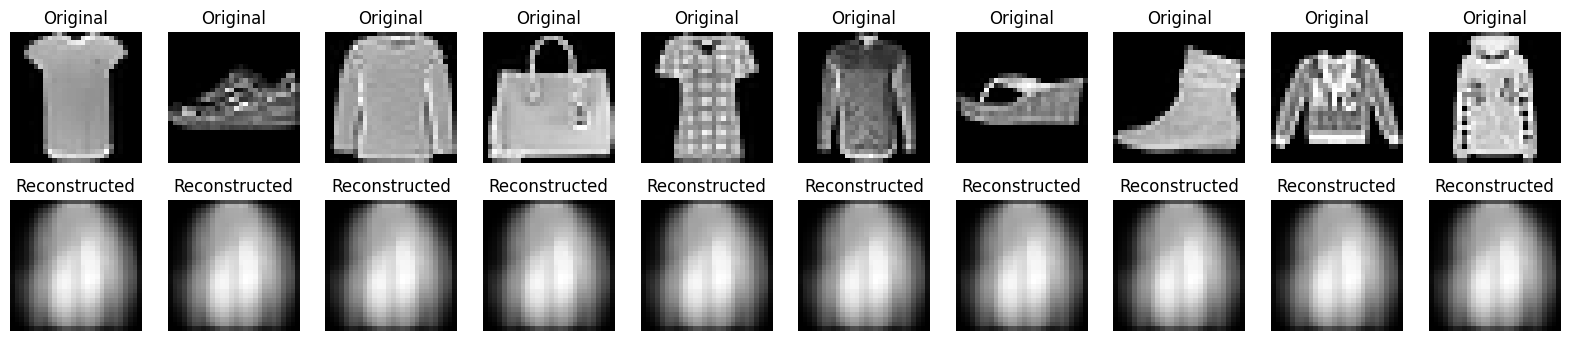

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from keras.losses import mse
from keras import backend as K

# Load the Fashion MNIST dataset
(x_train, _), (x_test, _) = fashion_mnist.load_data()

# Normalize pixel values to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Flatten the images
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Define the encoding and latent dimensions as variables
encoding_dim = 64  # Adjust as needed
latent_dim = 10    # Adjust as needed

# Encoder
input_img = Input(shape=(784,))
x = Dense(512, activation='relu')(input_img)  # Added Dense layer
x = Dense(256, activation='relu')(x)  # Added Dense layer
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

# Sampling function to sample from the latent space
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.0)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

# Decoder
decoder_input = Input(shape=(latent_dim,))
x = Dense(256, activation='relu')(decoder_input)  # Added Dense layer
x = Dense(512, activation='relu')(x)  # Added Dense layer
outputs = Dense(784, activation='sigmoid')(x)

# Create the encoder and decoder models
encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_input, outputs, name='decoder')

# VAE model, connecting the encoder and decoder
outputs = decoder(encoder(input_img)[2])
vae = Model(input_img, outputs, name='vae')

# KL divergence loss
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae.add_loss(K.mean(kl_loss))

vae.compile(optimizer=Adam(lr=0.001), loss=mse)

# Train the custom VAE (you should load pre-trained weights if available)
history = vae.fit(x_train, x_train, epochs=30, batch_size=128, validation_data=(x_test, x_test), verbose=2)

# Display a few original images and their reconstructed counterparts
n = 10  # Number of images to display
sample_indices = np.random.randint(0, len(x_test), n)
sample_images = x_test[sample_indices]
reconstructed_images = vae.predict(sample_images)

plt.figure(figsize=(20, 4))
for i in range(n):
    # Original Image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(sample_images[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

for i in range(n):
    # Reconstructed Image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()


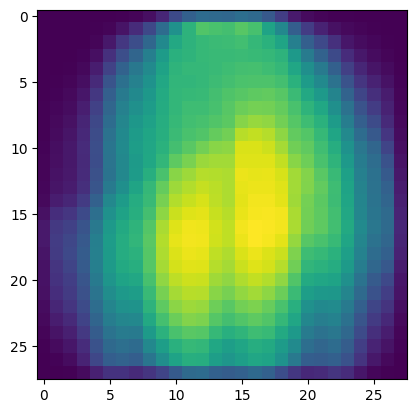

In [48]:
plt.imshow(reconstructed_images[6].reshape(28,28))


In [53]:
import os
import logging
import collections
import numpy as np
import tensorflow as tf
import imageio  # Import imageio
from tensorflow.keras.layers import Flatten, Dense, Input, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mean_squared_error, kl_divergence
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

class VAE(object):
    def __init__(self, flags, log_path=None):
        self.flags = flags
        self.image_size = (28, 28, 1)  # Fashion MNIST images are grayscale
        self.output_dim = np.prod(self.image_size)
        self.log_path = log_path
        self.n_hidden = 500

        self._init_logger()
        self._build_net()
        logger.info('Initialized VAE SUCCESS!')

    def _init_logger(self):
        if self.flags.is_train:
            tf_utils._init_logger(self.log_path)

    def _build_net(self):
        self.x_hat_tfph = Input(shape=self.image_size, name='input_img')
        self.x_tfph = Input(shape=self.image_size, name='target_img')
        self.keep_prob_tfph = Input(shape=(), dtype=tf.float32, name='keep_prob')
        self.z_in_tfph = Input(shape=(self.flags.z_dim,), name='latent_variable')

        # encoding
        mu, sigma = self.encoder(self.x_hat_tfph)
        # sampling by re-parameterization technique
        self.z = mu + sigma * tf.random.normal(shape=tf.shape(mu), mean=0., stddev=1., dtype=tf.float32)

        # decoding
        y = self.decoder(self.z)
        self.y = tf.clip_by_value(y, 1e-8, 1 - 1e-8)
        sample_y = self.decoder(self.z_in_tfph, is_reuse=True)
        self.sample_y = tf.clip_by_value(sample_y, 1e-8, 1 - 1e-8)

        # loss
        marginal_likelihood = tf.reduce_sum(self.x_tfph * tf.math.log(self.y) +
                                            (1 - self.x_tfph) * tf.math.log(1 - self.y), [1, 2, 3])
        KL_divergence = 0.5 * tf.reduce_sum(tf.square(mu) + tf.square(sigma) -
                                            tf.math.log(1e-8 + tf.square(sigma)) - 1, 1)

        self.marginal_likelihood = tf.reduce_mean(marginal_likelihood)
        self.KL_divergence = tf.reduce_mean(KL_divergence)
        self.ELBO = self.marginal_likelihood - self.KL_divergence
        self.loss = -self.ELBO

        self.train_op = tf.train.AdamOptimizer(self.flags.learning_rate).minimize(self.loss)

    def encoder(self, data, name='encoder'):
        with tf.variable_scope(name):
            x = Flatten()(data)

            # 1st hidden layer
            h0_linear = Dense(self.n_hidden, activation='relu', name='h0_linear')(x)
            h0_elu = Lambda(lambda x: tf.nn.elu(x), name='h0_elu')(h0_linear)
            h0_drop = tf.nn.dropout(h0_elu, rate=1.0 - self.keep_prob_tfph, name='h0_drop')

            # 2nd hidden layer
            h1_linear = Dense(self.n_hidden, activation='relu', name='h1_linear')(h0_drop)
            h1_tanh = Lambda(lambda x: tf.nn.tanh(x), name='h1_tanh')(h1_linear)
            h1_drop = tf.nn.dropout(h1_tanh, rate=1.0 - self.keep_prob_tfph, name='h1_drop')

            # 3rd hidden layer
            h2_linear = Dense(2 * self.flags.z_dim, name='h2_linear')(h1_drop)

            # The mean parameter is unconstrained
            mean = Lambda(lambda x: x[:, :self.flags.z_dim])(h2_linear)
            # The standard deviation must be positive.
            # Parameterize with a softplus and add a small epsilon for numerical stability
            stddev = 1e-6 + Lambda(lambda x: tf.nn.softplus(x[:, self.flags.z_dim:]))(h2_linear)

        return mean, stddev

    def decoder(self, z, name='decoder', is_reuse=False):
        with tf.variable_scope(name, reuse=is_reuse):
            # 1st hidden layer
            h0_linear = Dense(self.n_hidden, activation='relu', name='h0_linear')(z)
            h0_tanh = Lambda(lambda x: tf.nn.tanh(x), name='h0_tanh')(h0_linear)
            h0_drop = tf.nn.dropout(h0_tanh, rate=1.0 - self.keep_prob_tfph, name='h0_drop')

            # 2nd hidden layer
            h1_linear = Dense(self.n_hidden, activation='relu', name='h1_linear')(h0_drop)
            h1_elu = Lambda(lambda x: tf.nn.elu(x), name='h1_elu')(h1_linear)
            h1_drop = tf.nn.dropout(h1_elu, rate=1.0 - self.keep_prob_tfph, name='h1_drop')

            # 3rd hidden layer
            h2_linear = Dense(self.output_dim, activation='sigmoid', name='h2_linear')(h1_drop)

            output = Reshape(self.image_size)(h2_linear)

        return output

# Define your configuration
def plots(self, imgs, iter_time, save_file, prefix=None):
    # Reshape image from vector to (N, H, W, C)
    imgs_fake = np.reshape(imgs, (-1, self.image_size[0], self.image_size[1]))
    h_imgs, w_imgs = int(np.sqrt(imgs_fake.shape[0])), int(np.sqrt(imgs_fake.shape[0]))

    # Use imageio to save images
    imageio.imwrite(os.path.join(save_file, prefix + '_{}.png'.format(str(iter_time))),
                    (utils._merge(imgs_fake, size=[h_imgs, w_imgs], resize_ratio=1.) * 255).astype(np.uint8))


In [51]:
pip install imageio